Iota Calculation (Wendelstein 7-X)
==================================

This example shows how to calculate the rotational transform for Wendelstein 7-X. 

In [1]:
import fusionsc as fsc
from fusionsc.devices import w7x

First, we need to perform some setup to make sure W7-X data are available.

Note: The W7-X geometry is currently protected by the W7-X data access agreement. Therefore, the file referenced below is available to W7-X team members (including external collaborators who signed this agreement) upon request.

In [2]:
fsc.resolve.importOfflineData('../../w7x-op21.fsc')

Now we need to setup the geometry and magnetic field configuration. To speed up the magnetic field calculation, we use a slightly coarser grid.

In [3]:
field = w7x.standard()

grid = w7x.defaultGrid()
grid.nR = 128
grid.nZ = 128
grid.nPhi = 32

field = field.compute(grid)
await field

Finally, we need to decide in which phi planes we want to evaluate our Poincare plots, and which points to start our traces on.

In [4]:
import numpy as np
xStart = np.linspace(5.75, 6.25, 20)
yStart = 0 * xStart
zStart = 0 * xStart

Now it's time to run our calculation.

In [8]:
iotas = fsc.flt.calculateIota(field, [xStart, yStart, zStart], targetError = 1e-3, minStepSize = 0.001, unwrapEvery = 5)

In [9]:
# Shape is [5, nPlanes] + startsPoints.shape[1:] + [nTurns]
iotas.shape

(20,)

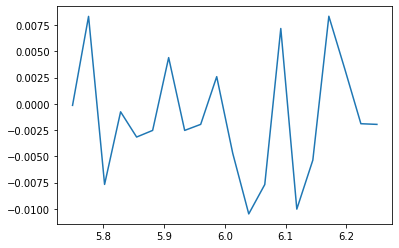

In [10]:
import matplotlib.pyplot as plt
plt.plot(xStart, iotas)